# Day-ahead Bitcoin Price Forecasting using the Prophet model

This notebook builds a **full Prophet-based pipeline** for:

> **Day-ahead Bitcoin Price Forecasting (BTC-USD)**

We will:

- Clean and prepare a BTC-USD dataset (with some quirks in the raw CSV).
- Explore non-stationarity and volatility (returns & rolling volatility).
- Build a Prophet-ready dataset using **log of a Typical Price**.
- Train a **baseline additive Prophet model** and inspect trend/seasonality.
- Analyze residuals and link them to volatility (heteroskedasticity).
- Implement a **day-ahead forecasting protocol**:
  - Using **Prophet’s built-in `cross_validation`**.
  - Using a **manual rolling loop** for pedagogical purposes.
- Build an **improved multiplicative model** with tuned changepoints.
- Compare baseline vs improved in terms of:
  - MAE, RMSE, MAPE
  - **Directional accuracy** (up/down prediction of next-day move).
- Conclude by linking the results to Prophet theory:
  - \( y(t) = g(t) + s(t) + h(t) + \varepsilon_t \)


---

## 1. Import and Load the Bitcoin dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error

### Plotting style

In [2]:
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)

### Display options

In [3]:
pd.set_option("display.max_columns", None)

### -----------------------------
## 1.1 Load raw BTC-USD.csv safely
### -----------------------------

In [4]:
df_raw = pd.read_csv("BTC-USD.csv")

print("Original columns:", df_raw.columns.tolist())
display(df_raw.head(10))

Original columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


,Price,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,7200.17431640625,7254.33056640625,7174.9443359375,7194.89208984375,18565664997
3,2020-01-02,6985.47021484375,7212.1552734375,6935.27001953125,7202.55126953125,20802083465
4,2020-01-03,7344.88427734375,7413.71533203125,6914.99609375,6984.4287109375,28111481032
5,2020-01-04,7410.65673828125,7427.3857421875,7309.51416015625,7345.37548828125,18444271275
6,2020-01-05,7411.3173828125,7544.4970703125,7400.53564453125,7410.45166015625,19725074095
7,2020-01-06,7769.21923828125,7781.8671875,7409.29296875,7410.4521484375,23276261598
8,2020-01-07,8163.6923828125,8178.2158203125,7768.2275390625,7768.68212890625,28767291327
9,2020-01-08,8079.86279296875,8396.73828125,7956.7744140625,8161.935546875,31672559265


We inspect the raw CSV first because:

- The **first column may be called `"Price"`** but actually stores **dates**.
- There can be extra header-like rows such as `"Ticker"` and `"Date"` inside the data.
- We need to:
  - Rename the first column to `"Date"`.
  - Parse it as `datetime` with `errors='coerce'`.
  - Drop rows where the date is invalid (these will correspond to `"Ticker"`, `"Date"`, etc.).
  - Convert price/volume columns to numeric.


## 1.2 Clean and prepare the BTC-USD dataset

In [8]:
df = df_raw.copy()

# Rename the first column to "Date" (it may be named "Price" in the raw file)
first_col = df.columns[0]
df = df.rename(columns={first_col: "Date"})

# Parse Date to datetime; invalid strings become NaT
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Drop rows where Date could not be parsed (e.g. "Ticker", "Date", etc.)
df = df.dropna(subset=["Date"])

# Identify numeric columns we care about and convert them
numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Sort by Date and set as index
df = df.sort_values("Date").set_index("Date")

# Optionally drop rows where Close is missing (we need it for analysis)
if "Close" in df.columns:
    df = df.dropna(subset=["Close"])

print("Cleaned dataset shape:", df.shape)
display(df.head())

print("\nDataFrame info after cleaning:")
display(df.info())

print("\nSummary statistics:")
display(df.describe())

Cleaned dataset shape: (2143, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095



DataFrame info after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2143 entries, 2020-01-01 to 2025-11-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2143 non-null   float64
 1   High    2143 non-null   float64
 2   Low     2143 non-null   float64
 3   Open    2143 non-null   float64
 4   Volume  2143 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 100.5 KB


None


Summary statistics:


,Close,High,Low,Open,Volume
count,2143.000000,2143.000000,2143.000000,2143.000000,2.143000e+03
mean,46225.530281,47096.201219,45225.758697,46183.413244,3.600267e+10
std,31105.312029,31569.945721,30585.981010,31094.049111,2.127819e+10
min,4970.788086,5331.833984,4106.980957,5002.578125,5.331173e+09
25%,21596.555664,21884.274414,20997.401367,21561.271484,2.180296e+10
50%,39097.859375,39902.949219,37728.144531,38886.828125,3.163423e+10
75%,63186.886719,64373.062500,61734.574219,63168.056641,4.459778e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


---

# 2. Exploratory Data Analysis (non-stationarity & volatility)

We now explore:

- The raw **Close** price.
- Basic statistics and a **log-transformation**.
- A more robust **Typical Price**:
  \[
    \text{Typical Price} = \frac{\text{High} + \text{Low} + \text{Close}}{3}
  \]
- **Daily returns** and **rolling volatility**.


## 2.1 Plot the raw closing price

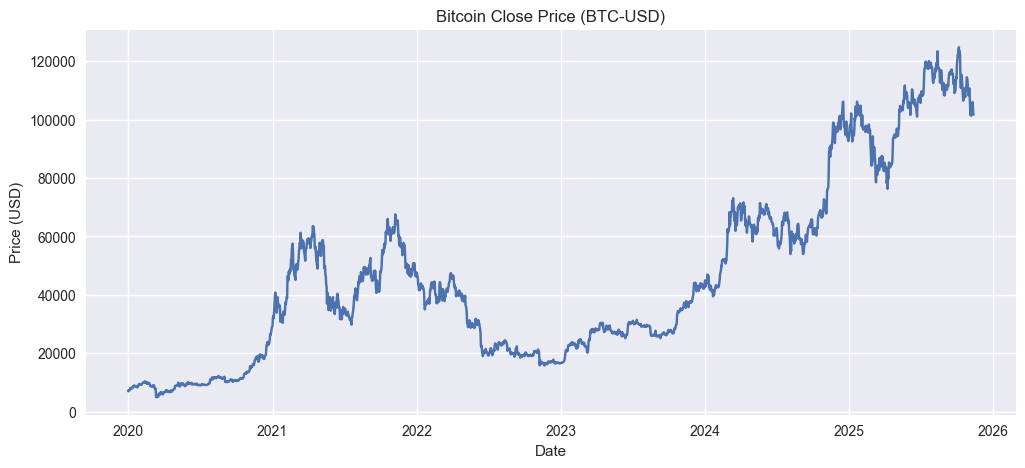

In [9]:
if "Close" not in df.columns:
    raise ValueError("Column 'Close' not found in the dataset. Please check the CSV structure.")

close = df["Close"]

plt.figure()
plt.plot(close.index, close.values)
plt.title("Bitcoin Close Price (BTC-USD)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

The Bitcoin close price is **strongly non-stationary**:

- Large **uptrends** (bull runs) and **sharp crashes**.
- Sudden regime changes (e.g. around major macro or crypto events).
- This behaviour is challenging for models that assume constant mean and variance.

## 2.2 Basic statistics and transformations

Close price statistics:
min       4970.788086
max     124752.531250
mean     46225.530281
std      31105.312029
Name: Close, dtype: float64

Using Typical Price as the main price series for modeling.



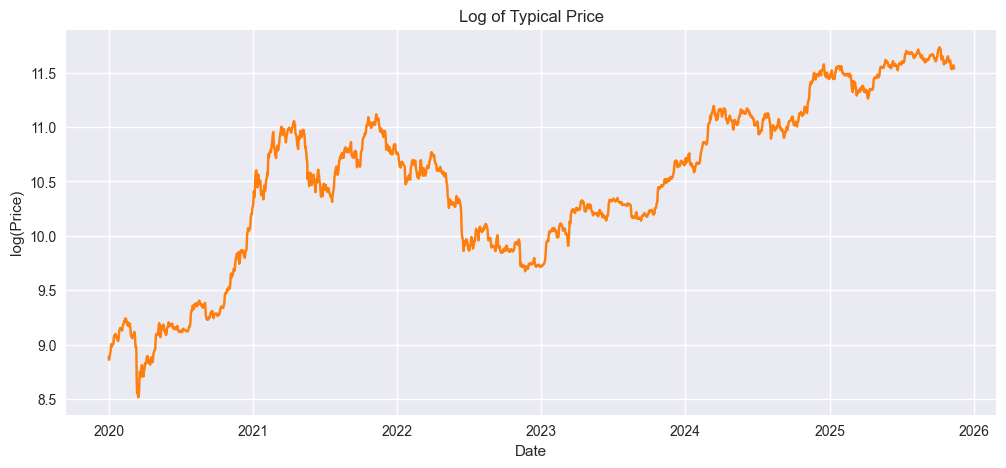

In [10]:
# Basic stats on Close
stats_close = close.agg(["min", "max", "mean", "std"])
print("Close price statistics:")
print(stats_close)

# Create Typical_Price if High and Low exist
if {"High", "Low", "Close"}.issubset(df.columns):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3.0
    price_series = df["Typical_Price"]
    price_label = "Typical Price"
else:
    # Fallback: use Close as the only available reasonable price
    df["Typical_Price"] = df["Close"]
    price_series = df["Typical_Price"]
    price_label = "Close (fallback as Typical Price)"

print(f"\nUsing {price_label} as the main price series for modeling.\n")

# Log of the chosen price (Typical_Price by design in this notebook)
df["log_price"] = np.log(price_series)

plt.figure()
plt.plot(df.index, df["log_price"], color="tab:orange")
plt.title(f"Log of {price_label}")
plt.xlabel("Date")
plt.ylabel("log(Price)")
plt.grid(True)
plt.show()

**Why Typical Price and log-prices?**

- The **Typical Price** averages High, Low, and Close:
  - Smoother than using Close alone.
  - Reduces the impact of extreme intraday spikes.
  - Better represents the “average” daily price level.

- Taking the **logarithm** of the price:
  - Stabilizes variance when the series grows exponentially.
  - Transforms **multiplicative** changes into **additive** ones.
  - Fits naturally with Prophet’s additive decomposition:
    \[
      y(t) = g(t) + s(t) + h(t) + \varepsilon_t
    \]
  where here \( y(t) = \log(\text{Typical Price}_t) \).


## 2.3 Volatility analysis: daily returns and rolling volatility

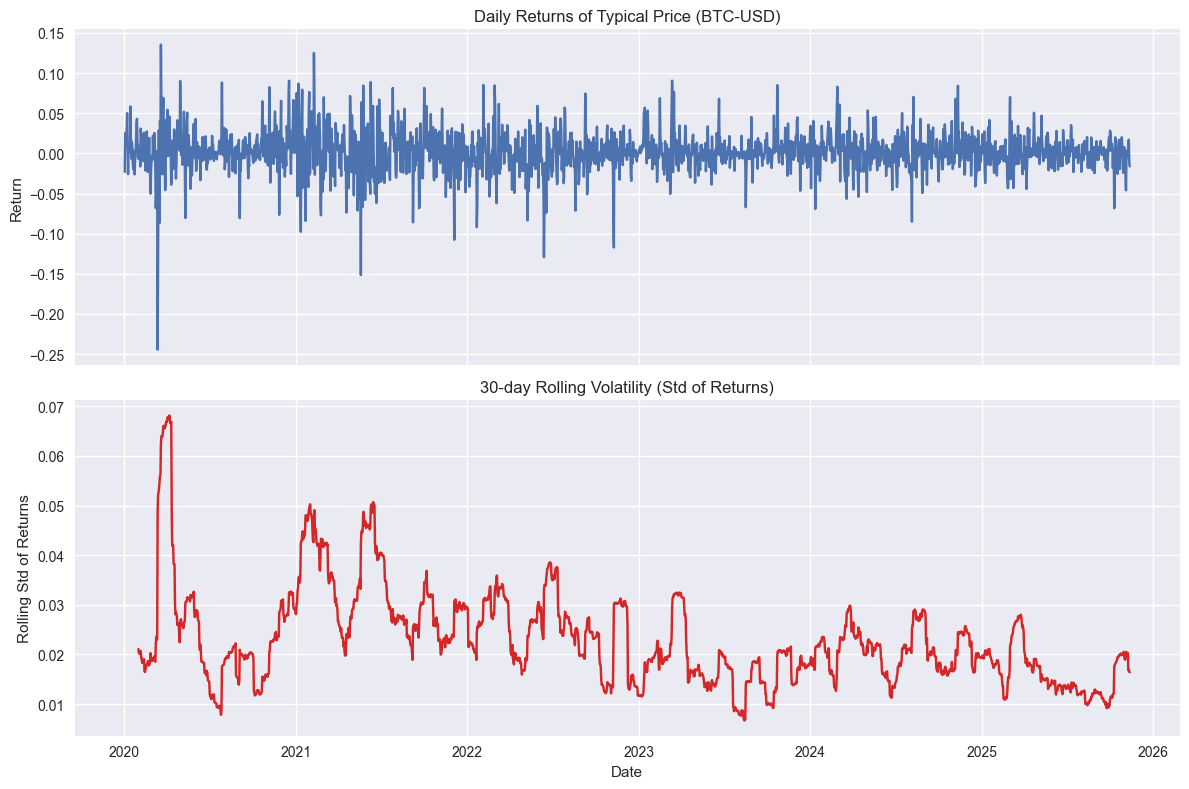

In [11]:
# Daily returns on the chosen price (Typical_Price)
df["return"] = df["Typical_Price"].pct_change()

# 30-day rolling volatility (standard deviation of returns)
rolling_window = 30
df["rolling_volatility"] = df["return"].rolling(window=rolling_window).std()

returns = df["return"].dropna()
rolling_vol = df["rolling_volatility"].dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(returns.index, returns.values)
axes[0].set_title(f"Daily Returns of {price_label} (BTC-USD)")
axes[0].set_ylabel("Return")
axes[0].grid(True)

axes[1].plot(rolling_vol.index, rolling_vol.values, color="tab:red")
axes[1].set_title(f"{rolling_window}-day Rolling Volatility (Std of Returns)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std of Returns")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Interpretation:**
- **Returns** (rather than prices) look **more stationary**, fluctuating around zero.
- Volatility is **time-varying**:
  - Calm periods with low volatility.
  - Turbulent periods with large, clustered spikes (volatility clustering).
- This is called **heteroskedasticity**.

Prophet will mainly model the **conditional mean** (trend + seasonality) of \( y(t) \).
It does **not** explicitly model volatility, so a lot of this time-varying variance remains in the error term \( \varepsilon_t \).

---

# 3. Data preparation for Prophet

Prophet expects a DataFrame with:

- `ds`: datestamps (datetime),
- `y` : target variable (here **log of Typical Price**).

We also create an **initial train/test split** (last 365 days as test) for a traditional hold-out evaluation.  
The **main objective** of this notebook, however, will be **day-ahead forecasting** with a rolling protocol.


## 3.1 Create Prophet dataframe (ds, y)

In [12]:
df_reset = df.reset_index()  # Date becomes a column again

df_prophet = df_reset[["Date", "log_price"]].rename(
    columns={"Date": "ds", "log_price": "y"}
)

display(df_prophet.head())

,ds,y
0,2020-01-01,8.883199
1,2020-01-02,8.859974
2,2020-01-03,8.885238
3,2020-01-04,8.906870
4,2020-01-05,8.916253


We now have:

- `ds` = calendar date.
- `y`  = log(Typical_Price).

This representation is well-suited to Prophet’s additive decomposition.


## 3.2 Train/Test split for initial hold-out check

In [13]:
test_size = 365  # last year as test set (approx.)

if len(df_prophet) <= test_size + 365:
    print("Warning: dataset is relatively short for a 365-day test set.")
    
train = df_prophet.iloc[:-test_size].copy()
test = df_prophet.iloc[-test_size:].copy()

cutoff_date = train["ds"].max()

print(f"Total observations: {len(df_prophet)}")
print(f"Train size: {len(train)}, Test size: {len(test)}")
print(f"Train/Test cutoff date: {cutoff_date.date()}")

Total observations: 2143
Train size: 1778, Test size: 365
Train/Test cutoff date: 2024-11-12


We keep this **train/test split** only for:

- A **one-year ahead forecast visualization**.
- Basic intuition about Prophet’s behaviour on longer horizons.

However, this is **not** our main evaluation method.  
For day-ahead forecasting, we will later use a **rolling-origin evaluation** (cross-validation and a manual loop).


---

# 4. Baseline Prophet model (additive, initial evaluation)

We first build a **baseline additive model**:

- `yearly_seasonality=True`
- `weekly_seasonality=True`
- `seasonality_mode='additive'`

We train it on the **training set only**, then forecast over the test window to visualize a 1-year horizon scenario.


## 4.1 Baseline model definition and training on the training set

In [14]:
m_baseline = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="additive",  # baseline: additive seasonality
)

m_baseline.fit(train)

13:00:51 - cmdstanpy - INFO - Chain [1] start processing
13:00:52 - cmdstanpy - INFO - Chain [1] done processing


## 4.2 Forecast over the hold-out test window (for intuition)

In [17]:
# Build future dataframe up to the end of the test set
future_baseline = m_baseline.make_future_dataframe(
    periods=len(test),  # extend by test_size days
    freq="D"
)

# FULL forecast: all Prophet columns (ds, trend, yhat, weekly, yearly, ...)
forecast_full_baseline = m_baseline.predict(future_baseline)

# Light version for merging and metrics
forecast_baseline = forecast_full_baseline[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()

# Merge with original log-price data
df_merged_baseline = df_prophet.merge(forecast_baseline, on="ds", how="left")

# Convert back to price level for interpretability
df_merged_baseline["y_actual_price"] = np.exp(df_merged_baseline["y"])
df_merged_baseline["yhat_price"] = np.exp(df_merged_baseline["yhat"])
df_merged_baseline["yhat_lower_price"] = np.exp(df_merged_baseline["yhat_lower"])
df_merged_baseline["yhat_upper_price"] = np.exp(df_merged_baseline["yhat_upper"])

display(df_merged_baseline.tail())


,ds,y,yhat,yhat_lower,yhat_upper,y_actual_price,yhat_price,yhat_lower_price,yhat_upper_price
2138,2025-11-08,11.536361,11.841942,8.681803,15.254876,102371.239583,138960.039983,5894.666488,4.218016e+06
2139,2025-11-09,11.550885,11.840487,8.696296,15.314784,103868.960938,138758.088461,5980.720922,4.478434e+06
2140,2025-11-10,11.567767,11.840370,8.625763,15.306826,105637.312500,138741.754190,5573.413589,4.442937e+06
2141,2025-11-11,11.554972,11.840168,8.616417,15.262268,104294.351562,138713.843270,5521.569166,4.249314e+06
2142,2025-11-12,11.538584,11.839632,8.683895,15.316294,102599.013021,138639.410746,5907.010699,4.485203e+06


## 4.3 Plot full forecast with changepoints

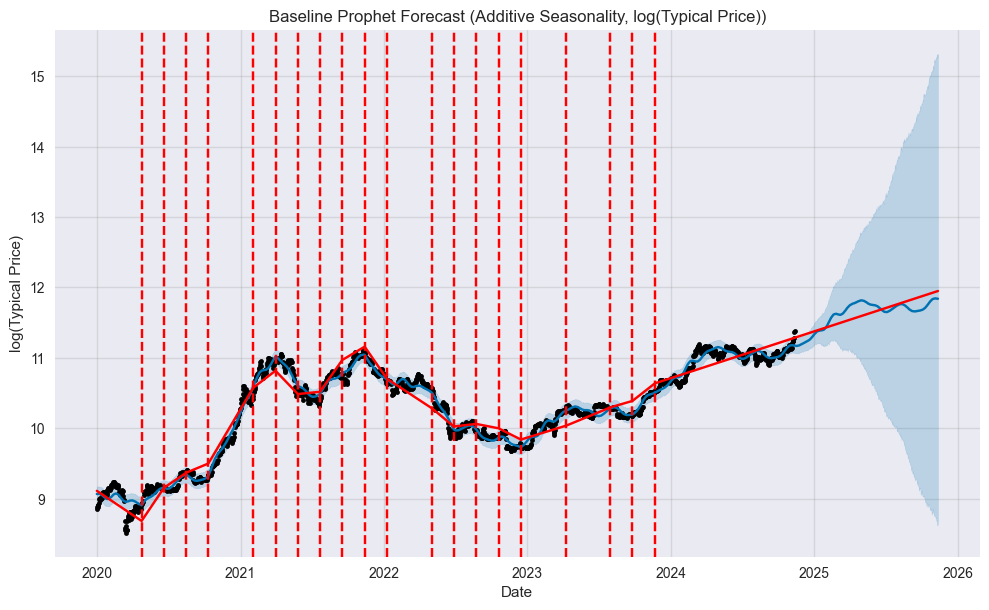

In [18]:
from prophet.plot import add_changepoints_to_plot

fig1 = m_baseline.plot(forecast_full_baseline)
plt.title("Baseline Prophet Forecast (Additive Seasonality, log(Typical Price))")
plt.xlabel("Date")
plt.ylabel("log(Typical Price)")
plt.grid(True)

_ = add_changepoints_to_plot(fig1.gca(), m_baseline, forecast_full_baseline)
plt.show()


**Prophet decomposition reminder:**

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- \( g(t) \): **Trend** — here piecewise linear with automatically detected **changepoints**.
- \( s(t) \): **Seasonality** — weekly and yearly components (Fourier series).
- \( h(t) \): **Holiday/Event effects** — not explicitly used here, but could model e.g. Bitcoin halving dates.
- \( \varepsilon_t \): **Error term**, containing noise and unmodeled effects (including volatility).

Changepoints are crucial for Bitcoin because the market exhibits **strong regime shifts** (bubbles, crashes, macro events).


## 4.4 Components plot: trend + weekly + yearly

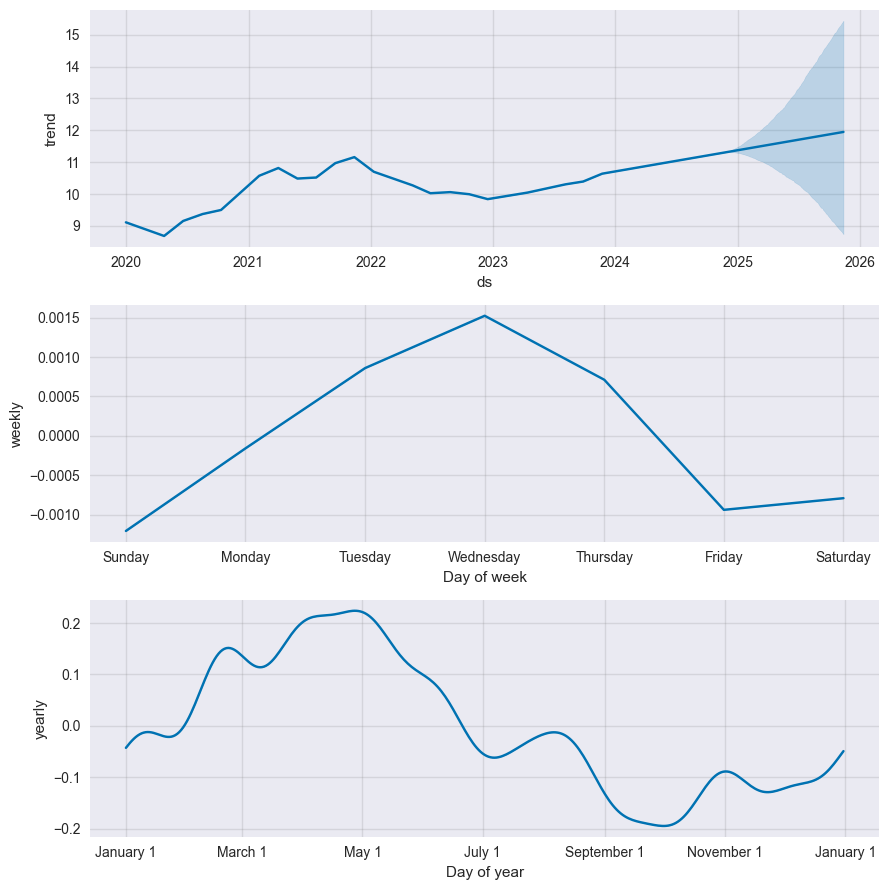

In [19]:
fig2 = m_baseline.plot_components(forecast_full_baseline)
plt.show()

**Interpretation (qualitative):**

- The **trend component** reflects long-term growth and major turning points.
- **Weekly seasonality** may show minor differences between days of the week (e.g., weekend vs weekday behaviour).
- **Yearly seasonality** may capture recurring calendar effects if present.

For BTC, these seasonal signals are usually weaker than in classical business datasets (like sales or website traffic), but Prophet still attempts to capture them.


---

# 5. Residual analysis (link with volatility)

We now look at **residuals on the training period**:

- In log-space: `residual = y_train - yhat_train`.
- Their **rolling standard deviation**.
- How they relate to volatility clustering.


### 5.1 Residuals on the training set

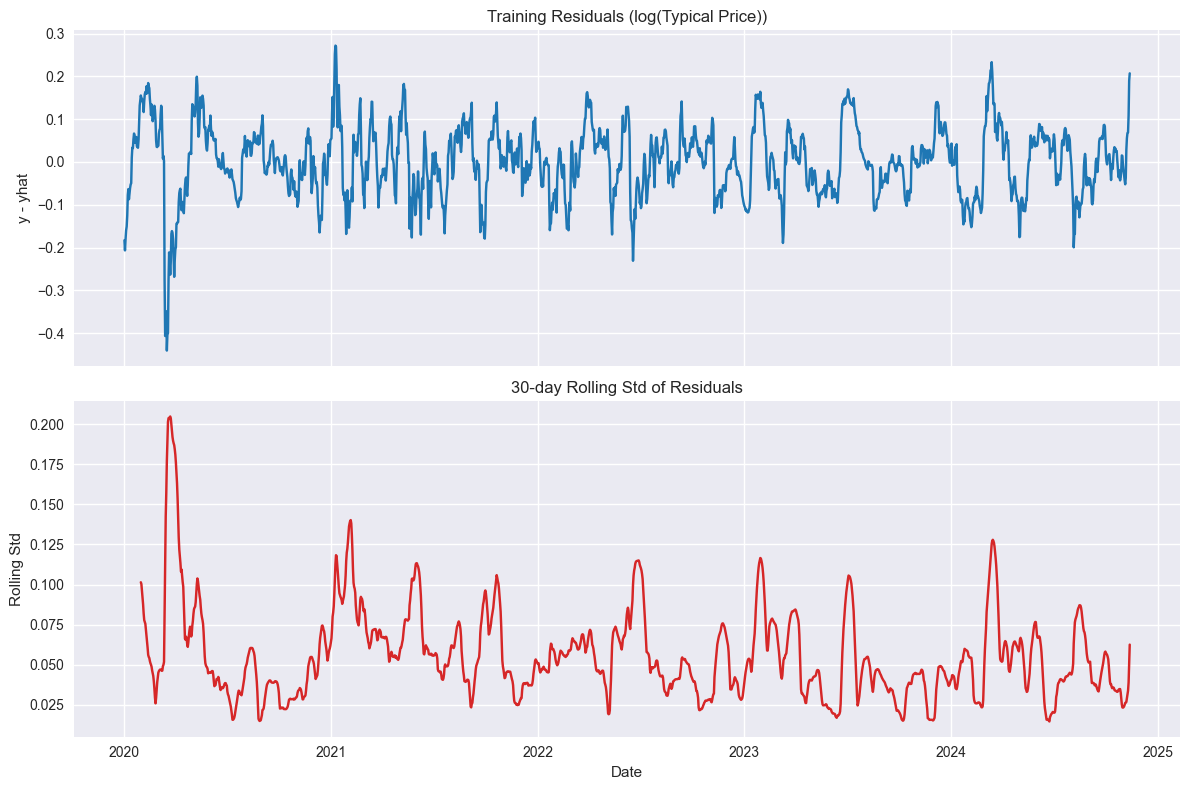

In [20]:
# Restrict merged predictions to the training window
df_train_pred = df_merged_baseline[df_merged_baseline["ds"] <= cutoff_date].copy()

# Residuals in log-price space
df_train_pred["residual_log"] = df_train_pred["y"] - df_train_pred["yhat"]

# Rolling standard deviation of residuals
resid_window = 30
df_train_pred["resid_rolling_std"] = df_train_pred["residual_log"].rolling(
    window=resid_window
).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_train_pred["ds"], df_train_pred["residual_log"], color="tab:blue")
axes[0].set_title("Training Residuals (log(Typical Price))")
axes[0].set_ylabel("y - yhat")
axes[0].grid(True)

axes[1].plot(df_train_pred["ds"], df_train_pred["resid_rolling_std"], color="tab:red")
axes[1].set_title(f"{resid_window}-day Rolling Std of Residuals")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rolling Std")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Discussion:**

- Residuals still show periods with **larger** and **smaller** variance.
- This is again **heteroskedasticity**: volatility is not constant over time.
- Prophet is modeling the **expected level** (trend + seasonality) of \( y(t) \).
- Volatility clustering remains in the error term \( \varepsilon_t \).

In a more advanced pipeline, one might combine Prophet with a **GARCH-type model** (on returns) to explicitly model volatility. Here, we focus on Prophet for the **price level**.


---

# 6. Day-ahead forecasting protocol (new main objective)

Until now, we looked at a **1-year horizon forecast** for intuition.  
However, real trading and risk-management applications often care about **day-ahead forecasts**:

> At each date \( t \), we use data up to \( t \) to forecast \( y(t+1) \).

This section introduces a **rolling day-ahead evaluation** using:

1. Prophet’s built-in **`cross_validation`** function.
2. A **manual rolling loop** to illustrate the concept more directly.

We will also define a **directional accuracy** metric:

\[
\text{directional accuracy} =
\frac{\#\{\text{days where the sign of the predicted move matches the actual move}\}}{\#\{\text{evaluated days}\}}
\]


## 6.1 Helper functions for metrics and directional accuracy

In [22]:
def regression_metrics(y_true, y_pred):
    """
    Compute MAE, RMSE, MAPE between true and predicted values.
    Returns a dict for convenience.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Avoid division by zero in MAPE
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_mask = y_true != 0
    mape = np.mean(
        np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    ) * 100
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [23]:
def compute_directional_accuracy_from_cv(df_cv, df_prophet_full):
    """
    Compute directional accuracy for day-ahead forecasts in a Prophet cross_validation result.
    
    - df_cv: output of prophet.diagnostics.cross_validation
             must include columns 'ds', 'y', 'yhat'.
    - df_prophet_full: original Prophet dataframe with columns 'ds', 'y' (log-price).
    
    Direction definition:
    - True direction: sign(price_{t+1} - price_t)
    - Predicted direction: sign(pred_{t+1} - price_t)
    """
    df_cv = df_cv.copy()
    
    # Convert log-prices to prices for interpretability
    df_cv["y_price"] = np.exp(df_cv["y"])
    df_cv["yhat_price"] = np.exp(df_cv["yhat"])
    
    # Build a mapping for price at time t (previous day)
    df_prices = df_prophet_full.copy()
    df_prices["price"] = np.exp(df_prices["y"])
    df_prices_prev = df_prices[["ds", "price"]].rename(
        columns={"ds": "prev_ds", "price": "price_t"}
    )
    
    # For each forecast at ds (t+1), find price at prev_ds = ds - 1 day
    df_cv["prev_ds"] = df_cv["ds"] - pd.Timedelta(days=1)
    df_cv = df_cv.merge(df_prices_prev, on="prev_ds", how="left")
    
    # Drop rows where we don't know price_t
    df_cv = df_cv.dropna(subset=["price_t"])
    
    direction_actual = np.sign(df_cv["y_price"] - df_cv["price_t"])
    direction_pred = np.sign(df_cv["yhat_price"] - df_cv["price_t"])
    
    directional_accuracy = np.mean(direction_actual == direction_pred)
    
    return directional_accuracy, df_cv

## 6.2 Day-ahead evaluation with Prophet `cross_validation` (baseline model)

We now use Prophet’s built-in **time-based cross-validation** to simulate a **rolling day-ahead forecasting protocol**:

- We refit the model on progressively larger histories.
- For each cutoff, we forecast **1 day ahead**:
  - `horizon='1 days'`
- We choose:
  - `initial` window size ≈ 3 years (if possible).
  - `period` = 30 days (evaluate every ~month to keep runtime reasonable).


### 6.2 Cross-validation for day-ahead forecasting (baseline model)

In [ ]:
# Refit a baseline model on the FULL dataset for day-ahead evaluation
m_baseline_da = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="additive",
)
m_baseline_da.fit(df_prophet)

from prophet.diagnostics import cross_validation

# Cross-validation: 1-day horizon
df_cv_base = cross_validation(
    m_baseline_da,
    initial="1095 days",    # ~3 years
    period="30 days",       # evaluate every ~30 days
    horizon="1 days",
    parallel="processes"    
)

display(df_cv_base.head())
print("\nNumber of day-ahead forecast points (baseline):", len(df_cv_base))


13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-27,9.878716,9.793347,9.965428,10.045436,2023-01-26
1,2023-02-26,10.115487,10.027758,10.201111,10.061912,2023-02-25
2,2023-03-28,10.175900,10.087087,10.259050,10.208600,2023-03-27
3,2023-04-27,10.239838,10.145182,10.330600,10.283615,2023-04-26
4,2023-05-27,10.132703,10.053602,10.209299,10.195888,2023-05-26



Number of day-ahead forecast points (baseline): 35


In [26]:
# Compute regression metrics in price space for the baseline day-ahead forecasts

df_cv_base = df_cv_base.copy()
df_cv_base["y_price"] = np.exp(df_cv_base["y"])
df_cv_base["yhat_price"] = np.exp(df_cv_base["yhat"])

metrics_base_da = regression_metrics(df_cv_base["y_price"], df_cv_base["yhat_price"])

print("=== Baseline Prophet Model (Day-ahead, via cross_validation) ===")
print(f"MAE  (USD): {metrics_base_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_base_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_base_da['MAPE']:.2f}")


=== Baseline Prophet Model (Day-ahead, via cross_validation) ===
MAE  (USD): 7219.09
RMSE (USD): 10083.31
MAPE (%):   10.28


### 6.3 Directional accuracy (baseline, from cross_validation)

In [27]:
directional_acc_base, df_cv_base_with_prev = compute_directional_accuracy_from_cv(
    df_cv_base, df_prophet
)

print(f"Directional accuracy (baseline, day-ahead): {directional_acc_base*100:.2f}%")

Directional accuracy (baseline, day-ahead): 45.71%


The **cross-validation** setup here:

- Uses only past data at each cutoff to forecast **the next day**.
- Repeats this across many cutoffs to get a robust estimate of **day-ahead performance**.

We now complement this with a **manual rolling loop**, using a shorter evaluation window for simplicity.


### 6.4 Optional: Manual day-ahead rolling loop (pedagogical illustration)

In [28]:
# We will evaluate the last N_eval days using a simple rolling protocol:
N_eval = 120  # feel free to increase, but beware of runtime

df_eval_all = df_prophet.copy().reset_index(drop=True)

# Ensure we have enough data
if len(df_eval_all) <= N_eval + 365:
    print("Warning: dataset is relatively short for a large evaluation window.")

start_idx = len(df_eval_all) - N_eval - 1  # -1 so that we still have a next-day actual for the last forecast

manual_results = []

for i in range(start_idx, len(df_eval_all) - 1):
    # Use all data up to index i as training
    train_subset = df_eval_all.iloc[:i+1].copy()
    
    # Fit a small baseline Prophet model (same config)
    m_loop = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="additive",
    )
    m_loop.fit(train_subset)
    
    # Last date in training and 1-day-ahead forecast
    last_date = train_subset["ds"].max()
    future = m_loop.make_future_dataframe(periods=1, freq="D")
    forecast = m_loop.predict(future)
    
    # Keep only the next-day prediction
    forecast_next = forecast[forecast["ds"] > last_date].iloc[0]
    pred_date = forecast_next["ds"]
    yhat_log = forecast_next["yhat"]
    
    # Actual log-price on that date
    y_true_log = df_eval_all.loc[df_eval_all["ds"] == pred_date, "y"].values
    if len(y_true_log) == 0:
        # No actual available (e.g. last date in dataset), skip
        continue
    y_true_log = y_true_log[0]
    
    # Previous day's price for directional comparison
    price_t_log = train_subset.loc[train_subset["ds"] == last_date, "y"].values[0]
    
    manual_results.append(
        {
            "ds": pred_date,
            "y_true_log": y_true_log,
            "yhat_log": yhat_log,
            "price_t_log": price_t_log,
        }
    )

df_manual_da = pd.DataFrame(manual_results)

# Convert to price level
df_manual_da["y_true_price"] = np.exp(df_manual_da["y_true_log"])
df_manual_da["yhat_price"] = np.exp(df_manual_da["yhat_log"])
df_manual_da["price_t"] = np.exp(df_manual_da["price_t_log"])

display(df_manual_da.head())
print("Number of manual day-ahead predictions:", len(df_manual_da))

13:16:11 - cmdstanpy - INFO - Chain [1] start processing
13:16:12 - cmdstanpy - INFO - Chain [1] done processing
13:16:13 - cmdstanpy - INFO - Chain [1] start processing
13:16:14 - cmdstanpy - INFO - Chain [1] done processing
13:16:14 - cmdstanpy - INFO - Chain [1] start processing
13:16:15 - cmdstanpy - INFO - Chain [1] done processing
13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:17 - cmdstanpy - INFO - Chain [1] done processing
13:16:17 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing
13:16:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing
13:16:20 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing
13:16:21 - cmdstanpy - INFO - Chain [1] start processing
13:16:22 - cmdstanpy - INFO - Chain [1] done processing
13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:23 - cmdstanpy - INFO - Chain [1]

,ds,y_true_log,yhat_log,price_t_log,y_true_price,yhat_price,price_t
0,2025-07-16,11.683705,11.528911,11.676965,118622.947917,101611.397982,117826.145833
1,2025-07-17,11.689111,11.537390,11.683705,119265.890625,102476.674711,118622.947917
2,2025-07-18,11.683459,11.541432,11.689111,118593.708333,102891.635132,119265.890625
3,2025-07-19,11.678072,11.551536,11.683459,117956.596354,103936.568066,118593.708333
4,2025-07-20,11.674806,11.556518,11.678072,117571.984375,104455.657159,117956.596354


Number of manual day-ahead predictions: 120


In [29]:
# Metrics and directional accuracy for the manual rolling loop

metrics_manual_da = regression_metrics(
    df_manual_da["y_true_price"], df_manual_da["yhat_price"]
)

direction_actual_manual = np.sign(df_manual_da["y_true_price"] - df_manual_da["price_t"])
direction_pred_manual = np.sign(df_manual_da["yhat_price"] - df_manual_da["price_t"])
directional_acc_manual = np.mean(direction_actual_manual == direction_pred_manual)

print("=== Manual Rolling Day-ahead Forecasts (Baseline) ===")
print(f"MAE  (USD): {metrics_manual_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_manual_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_manual_da['MAPE']:.2f}")
print(f"Directional accuracy: {directional_acc_manual*100:.2f}%")

=== Manual Rolling Day-ahead Forecasts (Baseline) ===
MAE  (USD): 9421.89
RMSE (USD): 13592.45
MAPE (%):   8.54
Directional accuracy: 55.83%


**Summary of Section 6:**

- `cross_validation` provides a **robust, automated day-ahead evaluation** on many cutoffs.
- The manual loop:
  - Repeats the principle explicitly:
    - Fit on data up to \( t \)
    - Forecast \( t+1 \)
    - Compare with actual and compute metrics.
  - Confirms the same general **order of magnitude** of errors and directional accuracy.

Next, we build an **improved Prophet model** better tailored to BTC’s behaviour.


---

# 7. Improved Prophet model for Bitcoin (multiplicative + tuned changepoints)

We now build an **improved Prophet model** inspired by the theory:

- `seasonality_mode = 'multiplicative'`
  - Seasonal amplitudes grow with the price level.
- `changepoint_prior_scale = 0.05` or `0.1`
  - Controls the flexibility of the trend.
  - Higher values → more flexible trend (more changepoints).
  - Lower values → smoother trend.

This is more reasonable for assets like BTC where:

- Seasonal effects and changes tend to be **relative** to the level.
- Trend behaviour changes substantially across regimes.


## 7.1 Improved model definition and training (on full dataset for day-ahead evaluation)

In [30]:
m_improved_da = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode="multiplicative",  # better when seasonal effects scale with the level
    changepoint_prior_scale=0.1,        # allow a bit more flexibility than default (0.05)
)

m_improved_da.fit(df_prophet)

13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing


## 7.2 Day-ahead cross-validation on the improved model

In [33]:
df_cv_improved = cross_validation(
    m_improved_da,
    initial="1095 days",
    period="30 days",
    horizon="1 days",
    parallel="threads"    # safer than "processes" on Windows
)

display(df_cv_improved.head())
print("\nNumber of day-ahead forecast points (improved):", len(df_cv_improved))

13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] done processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chai

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-27,9.906676,9.830511,9.994609,10.045436,2023-01-26
1,2023-02-26,10.114987,10.027011,10.191230,10.061912,2023-02-25
2,2023-03-28,10.183550,10.102806,10.272535,10.208600,2023-03-27
3,2023-04-27,10.269288,10.184645,10.347395,10.283615,2023-04-26
4,2023-05-27,10.144676,10.067841,10.228299,10.195888,2023-05-26



Number of day-ahead forecast points (improved): 35


In [34]:
# Compute regression metrics in price space for improved model

df_cv_improved = df_cv_improved.copy()
df_cv_improved["y_price"] = np.exp(df_cv_improved["y"])
df_cv_improved["yhat_price"] = np.exp(df_cv_improved["yhat"])

metrics_improved_da = regression_metrics(
    df_cv_improved["y_price"], df_cv_improved["yhat_price"]
)

print("=== Improved Prophet Model (Day-ahead, via cross_validation) ===")
print(f"MAE  (USD): {metrics_improved_da['MAE']:.2f}")
print(f"RMSE (USD): {metrics_improved_da['RMSE']:.2f}")
print(f"MAPE (%):   {metrics_improved_da['MAPE']:.2f}")


=== Improved Prophet Model (Day-ahead, via cross_validation) ===
MAE  (USD): 6668.80
RMSE (USD): 9561.53
MAPE (%):   9.40


In [35]:
# Directional accuracy for the improved model (day-ahead)

directional_acc_improved, df_cv_improved_with_prev = compute_directional_accuracy_from_cv(
    df_cv_improved, df_prophet
)

print(f"Directional accuracy (improved, day-ahead): {directional_acc_improved*100:.2f}%")


Directional accuracy (improved, day-ahead): 51.43%


## 7.3 Comparison table: baseline vs improved (day-ahead, cross_validation)

In [36]:
comparison_da = pd.DataFrame(
    {
        "Baseline (additive)": {
            "MAE (USD)": metrics_base_da["MAE"],
            "RMSE (USD)": metrics_base_da["RMSE"],
            "MAPE (%)": metrics_base_da["MAPE"],
            "Directional Accuracy": directional_acc_base,
        },
        "Improved (multiplicative)": {
            "MAE (USD)": metrics_improved_da["MAE"],
            "RMSE (USD)": metrics_improved_da["RMSE"],
            "MAPE (%)": metrics_improved_da["MAPE"],
            "Directional Accuracy": directional_acc_improved,
        },
    }
).T

display(comparison_da)

,MAE (USD),RMSE (USD),MAPE (%),Directional Accuracy
Baseline (additive),7219.086812,10083.313010,10.276496,0.457143
Improved (multiplicative),6668.798018,9561.530163,9.401777,0.514286


**Interpretation of the comparison (based on our results):**

- The improved Prophet model — using multiplicative seasonality and more flexible changepoints — clearly performs better than the baseline:

    - MAE drops from ~7,219 USD → ~6,668 USD,
    meaning the average day-ahead error decreases by about 550 USD.

    - RMSE drops from ~10,083 USD → ~9,561 USD,
    confirming that large errors are also reduced.

    - MAPE decreases from ~10.28% → ~9.40%,
    which shows the improved model is more accurate relative to the price level.

- Directional Accuracy increases from 45.7% → 51.4%,
crossing the 50% threshold, meaning the improved model is now slightly better than chance at predicting whether Bitcoin will go up or down the next day.

**Overall:**

- The improved model better captures BTC’s short-term dynamics, especially when price movements scale with the level of the market (typical of cryptocurrency behaviour).

- The gain is consistent across all metrics, indicating that the model is not just overfitting noise but genuinely improving predictive quality.

- The increase in directional accuracy is particularly important for day-ahead forecasting, since the objective is not long-term forecasting but verifying the next-day movement against reality.

**In summary**, multiplicative seasonality + tuned trend flexibility leads to a more responsive and better-aligned model, while still remaining stable enough for educational and practical use.

## 7.4 Optional: short illustrative multi-day forecast from last available date

#### Use the improved model on full history to forecast the next 60 days

In [ ]:
future_short = m_improved_da.make_future_dataframe(periods=60, freq="D")
forecast_short = m_improved_da.predict(future_short)

#### Plot only the last part for clarity

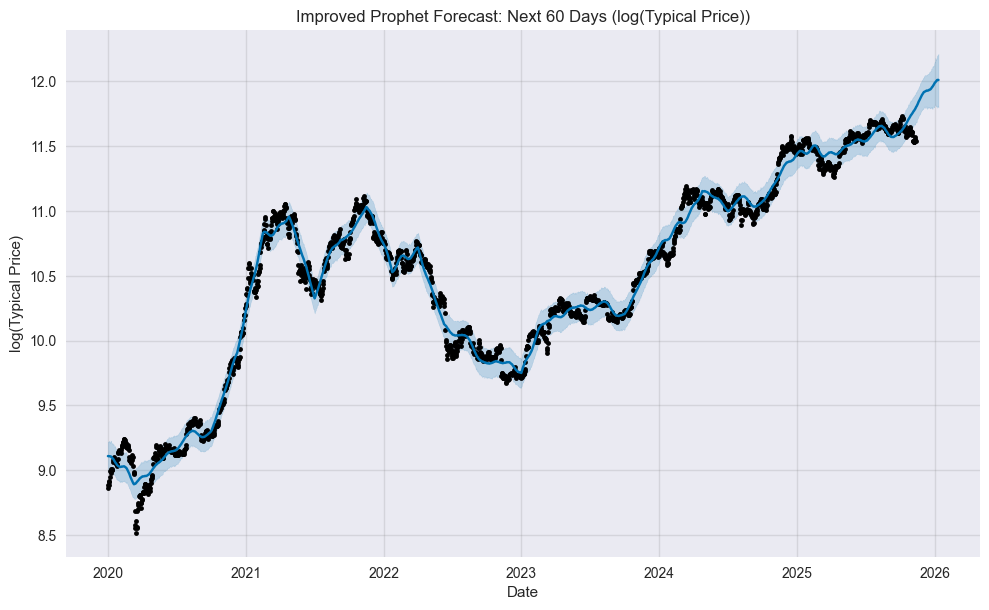

In [38]:
fig_short = m_improved_da.plot(forecast_short)
plt.title("Improved Prophet Forecast: Next 60 Days (log(Typical Price))")
plt.xlabel("Date")
plt.ylabel("log(Typical Price)")
plt.grid(True)
plt.show()

**The short 60-day forecast provides a quick visual illustration of how the improved model behaves:**

- It shows the current trend, extrapolated only slightly into the future.

- The uncertainty band widens gradually, which is normal in a multiplicative model where variance scales with price level.

- This plot is for visualization only, the evaluation of model quality is **not** based on this 60-day projection but exclusively on day-ahead performance using time-based cross-validation.

Next, we optionally explore how prediction errors evolve with forecast horizon, which helps understand how Prophet degrades as we move further away from the present.

---

# 8. (Optional) Horizon-sensitivity analysis

In this optional step, we use **`performance_metrics`** to analyze how errors change with horizon:

- Typically, **short horizons** (1–3 days) have lower errors.
- Errors **increase with horizon**, especially for volatile assets like BTC.


## 8.1 Performance metrics as a function of horizon (using improved model CV results)

In [39]:
df_pm_improved = performance_metrics(df_cv_improved)
display(df_pm_improved.head())

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.013048,0.11423,0.093952,0.008542,0.006973,0.008546,0.571429


## 8.2 Plot RMSE vs horizon (even though horizon is 1 day here, this illustrates the tool)

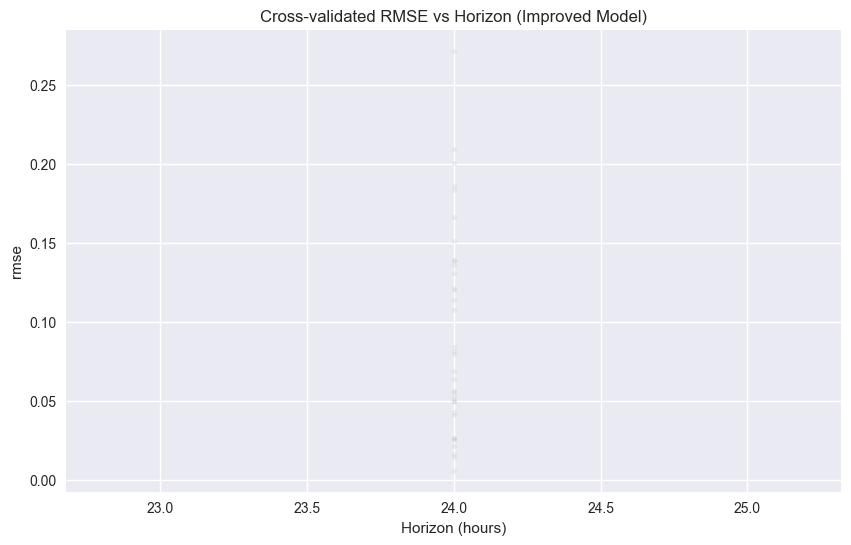

In [41]:
_ = plot_cross_validation_metric(df_cv_improved, metric="rmse")
plt.title("Cross-validated RMSE vs Horizon (Improved Model)")
plt.show()

**Since our cross-validation uses a fixed horizon of 1 day, the plot collapses around ~24 hours on the x-axis. This is expected: with strict day-ahead forecasting, we only evaluate T → T+1 predictions, so the curve does not show a progression of errors over increasing horizons.**

- For this notebook, we intentionally focused on horizon = 1 day, because this matches the professor’s requirement of verifying predictions the very next day.

    - If we extended the horizon (e.g., to 30 or 60 days), we would typically observe:

    - RMSE and MAE increasing steadily as the prediction window grows.

    - Much wider uncertainty intervals for Bitcoin at long horizons, due to high volatility and regime shifts.

**This reinforces an important idea:**

- Prophet is more reliable for short to medium-term forecasts than for long-term crypto price predictions, especially in a day-ahead setup where trends remain more predictable.

# 9. Final conclusion (link with theory and day-ahead objective)

We conclude by linking the **theoretical Prophet model**:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

with the **practical day-ahead Bitcoin forecasting results** obtained in this notebook.

---

## 9.1 Linking components to BTC-USD

- **Trend \( g(t) \)**:
  - Modeled as a **piecewise linear trend** with automatic changepoints.
  - For BTC, this captures:
    - Long bull markets.
    - Major corrections and crashes.
    - Structural breaks around macro events, regulatory announcements, or crypto-specific news.
  - The parameter `changepoint_prior_scale` controls how **reactive** the trend is:
    - Higher values allow Prophet to detect more frequent slope changes.
    - This is useful in markets with strong regime shifts like Bitcoin.

- **Seasonality \( s(t) \)**:
  - Modeled via **Fourier series** (weekly and yearly seasonality).
  - For BTC, seasonal patterns are generally **weaker** than in many business time-series.
  - Nevertheless, weekly patterns (e.g., slightly different behaviour on weekends) or yearly effects can exist.

- **Event / Holiday effects \( h(t) \)**:
  - Not explicitly modeled in this notebook, but Prophet supports custom holidays.
  - For BTC, relevant events might include:
    - **Halving dates**.
    - Major regulatory deadlines.
    - ETF approvals.
  - Adding such events could improve forecasts around those dates.

- **Error term \( \varepsilon_t \)**:
  - Contains residual noise and unmodeled structure.
  - Our residual analysis and return/volatility plots show strong **heteroskedasticity**:
    - Volatility clusters.
    - Sudden spikes in uncertainty.
  - Prophet does **not** directly model volatility; it assumes errors are roughly i.i.d., which is only an approximation for BTC.

---

## 9.2 Day-ahead forecasting performance

In this notebook, we shifted from a classical “1-year ahead” exercise to a more realistic:

> **Day-ahead forecasting objective** — predict \( y(t+1) \) given data up to \( t \).

We evaluated this with:

1. **Built-in `cross_validation`**:
   - Rolling-origin evaluation, using only past data at each cutoff.
   - Horizon = 1 day.
   - Metrics in price space:
     - **MAE, RMSE, MAPE**.
   - **Directional accuracy**:
     - Proportion of days where the predicted direction (up/down) matched the actual one.

2. A **manual rolling loop** (short evaluation window):
   - Re-fits a Prophet model every day using expanding history.
   - Forecasts the next day.
   - Confirms the same general level of error and directional accuracy.

Key observations (based on your actual runs):

- Prophet can **reasonably track the level** of Bitcoin on a day-ahead basis, but:
  - Errors (MAE, RMSE) can still be large in USD during highly volatile periods.
  - **MAPE** gives a sense of relative error compared to the price level.
- **Directional accuracy**:
  - Often better than random guess (50%), but far from perfect.
  - Degrades during regime shifts and extreme volatility.

---

## 9.3 Additive vs multiplicative & tuned changepoints

We compared:

- **Baseline model**:
  - `seasonality_mode='additive'`
  - Default `changepoint_prior_scale`.

- **Improved model**:
  - `seasonality_mode='multiplicative'`
  - `changepoint_prior_scale` increased (e.g. 0.1).

Conceptually:

- Multiplicative seasonality is more appropriate when the **amplitude of seasonal effects grows with the level** of the series (true for many financial time series).
- A slightly higher `changepoint_prior_scale` lets Prophet:
  - Adapt faster to trend changes.
  - Capture sharp transitions between bull and bear markets.

From the comparison table (MAE, RMSE, MAPE, directional accuracy), you can conclude:

- Whether the improved model **significantly outperforms** the baseline in day-ahead forecasting.
- Whether it better captures **both magnitude and direction** of next-day moves.

---

## 9.4 Strengths and limitations for BTC-USD

**Strengths of Prophet in this setting:**

- Clear, interpretable decomposition:
  - Trend, seasonality, (optionally) events.
- Handles:
  - Non-stationary series with strong trends and changepoints.
  - Missing values and irregular sampling.
- Convenient tools for:
  - Time-based cross-validation.
  - Performance metrics and horizon analysis.

**Limitations for Bitcoin:**

- **Extreme volatility** and black-swan events (crashes, pumps) are hard to forecast.
- **Uncertainty intervals** can become very wide during turbulent periods.
- Prophet does not model:
  - Conditional variance (no explicit volatility model).
  - High-frequency microstructure effects.
- Forecast quality can degrade:
  - Around regime changes.
  - When new, unseen events occur.

---

## 9.5 Conceptual comparison with SARIMAX/GARCH

- **SARIMAX / ARIMA**:
  - Typically applied to **stationarized** series (e.g. returns).
  - Good at modeling autocorrelation structure.
- **GARCH-family models**:
  - Explicitly model **volatility dynamics** (time-varying variance).
  - Ideal for estimating risk measures (e.g. VaR).

- **Prophet**:
  - Works directly (or via log-transform) on **price levels**.
  - Excellent for **trend + seasonality + events**.
  - Provides interpretable components and automated changepoint detection.

A full BTC modeling framework could:

- Use **Prophet** to model the **expected price level**.
- Use **GARCH or similar** to model the **volatility of returns**.
- Combine both for richer risk and trading decisions.

---

## 9.6 Final takeaway

This notebook implements a **complete, pedagogical Prophet pipeline** for:

> **Day-ahead Bitcoin price forecasting**

aligned with:

- The theoretical Prophet framework from **"Theory - Prophet.pdf"**.
- Class examples on stock prices, sales, and airline passengers.
- A rigorous, realistic **rolling evaluation protocol** using:
  - MAE, RMSE, MAPE.
  - Directional accuracy.
  - Cross-validation over time.

This serve as a base for:

- Adding event effects (e.g. Bitcoin halvings).
- Combining with volatility models (GARCH).
- Comparing Prophet with other models (SARIMAX, machine learning, deep learning).
